In [1]:
%matplotlib inline
#%matplotlib notebook

For high dpi displays.

In [2]:
%config InlineBackend.figure_format = 'retina'

# 0. General note

- This notebook fits a BM3 EoS and propagates uncertainties.
- Primarily uses burnman and LMFit packages.
- Loads in data from single LOG files.
- Loads in ruby spectrum .asc files.
- Fits ruby spectrum with 2 Lorentzians and a linear background.
- John Lazarz - 171129

# 1. General setup

In [3]:
import os
import sys
import numpy as np
from scipy import constants as con
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import uncertainties as uct
from uncertainties import unumpy as unp
from lmfit import Model
from lmfit.models import LinearModel, LorentzianModel
import pandas as pd
from IPython.display import display
import burnman
import glob
import re

In [4]:
if not os.path.exists('burnman') and os.path.exists('../burnman'):
    sys.path.insert(1, os.path.abspath('..'))

### What sample is this? - Where are the data folders?

In [5]:
sample = 'Acetaminophen'
T = 298.15

ruby_path = r'C:\Users\Huber\Box Sync\X-ray\acetaminophen\ruby'
log_path = r'C:\Users\Huber\Box Sync\X-ray\acetaminophen'

if os.path.exists(os.path.abspath(ruby_path)):
    ruby_folder = os.path.abspath(ruby_path)
    log_folder = os.path.abspath(log_path)
    print('Using Huber working directory.')
else:
    ruby_path = r'C:\Users\Raman\Box Sync\X-ray\acetaminophen\ruby'
    log_path = r'C:\Users\Raman\Box Sync\X-ray\acetaminophen'
    
    if os.path.exists(os.path.abspath(ruby_path)):
        ruby_folder = os.path.abspath(ruby_path)
        log_folder = os.path.abspath(log_path)
        print('Using Raman working directory.')
    else:
        print('Directory does not exist.......')


Using Huber working directory.


# 2. Read data

Load in the .log files from directory as well as ruby .asc files from a folder named "ruby" within the directory.


In [6]:
#idx_file = 0
#sample = logs[idx_file]
os.chdir(ruby_folder)
rubys = glob.glob('*.asc')
print('%s\n' % rubys)
print(sample)

['acetdac_p0_0.04s_4acc_f7_1200g_171117.asc', 'acetdac_p0_table_0.04s_4acc_f7_1200g_171117.asc']

Acetaminophen


# 3. Organize and fit data

First, we sort the ruby spectra into 2 lists. One list for 'table_rubys' and one list for 'sample_rubys'.

#### extract_ruby
In the 'extract_ruby' function we load the ruby spectrum from '.asc' files into lists. We then fit the data in the 'ruby_fit' funciton using the (Dawaele et al. 2008) equation to determine pressure. 

#### extract_cell
In the 'extract_cell' function we extract the cell information from the log file. This section searches through the log file and loads lattice parameters from the **last** "lsq" and the **last** "clsq" performed in Single in that log file. These lattice parameters, as well as standard deviations, are loaded into "cell" dictionary. 

Parameters collected from both "lsq" and "clsq": a, a_sigma, b, b_sigma, c, c_sigma, alpha, alpha_sigma, beta, beta_sigma ,gamma, gamma_sigma, volume, volume_sigma

To access parameters example:
 - To print "a" parameter from "lsq" function:
     - print(cell["lsq"]["a"])
 - To print "a_sigma" parameter from "clsq" function:
     - print(cell["clsq"]["a_sigma"])

In [7]:
table_rubys = []
sample_rubys = []
for i in  rubys:
    if re.search('table',i):
        table_rubys.append(i)
    else:
        sample_rubys.append(i)

[[Model]]
    ((Model(lorentzian, prefix='r1_') + Model(lorentzian, prefix='r2_')) + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 301
    # data points      = 1600
    # variables        = 8
    chi-square         = 0.087
    reduced chi-square = 0.000
    Akaike info crit   = -15696.319
    Bayesian info crit = -15653.297
[[Variables]]
    lin_intercept:  -0.23466146 +/- 0.007868 (3.35%) (init=-0.2085142)
    lin_slope:       0.00034931 +/- 1.13e-05 (3.25%) (init= 0.0003522253)
    r1_center:       694.378927 +/- 0.000954 (0.00%) (init= 694.3)
    r1_amplitude:    1.08979976 +/- 0.003402 (0.31%) (init= 1)
    r1_sigma:        0.35064313 +/- 0.001467 (0.42%) (init= 0.000954)
    r1_fwhm:         0.70128627 +/- 0.002935 (0.42%)  == '2.0000000*r1_sigma'
    r1_height:       0.98930797 +/- 0.002658 (0.27%)  == '0.3183099*r1_amplitude/max(1.e-15, r1_sigma)'
    r2_center:       692.938477 +/- 0.001351 (0.00%) (init= 692.9)
    r2_amplitude:    0.51382971 +/- 0.

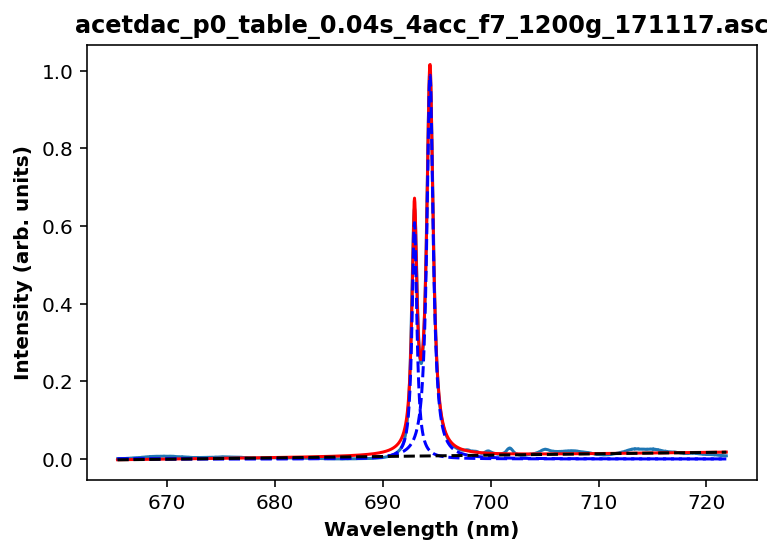

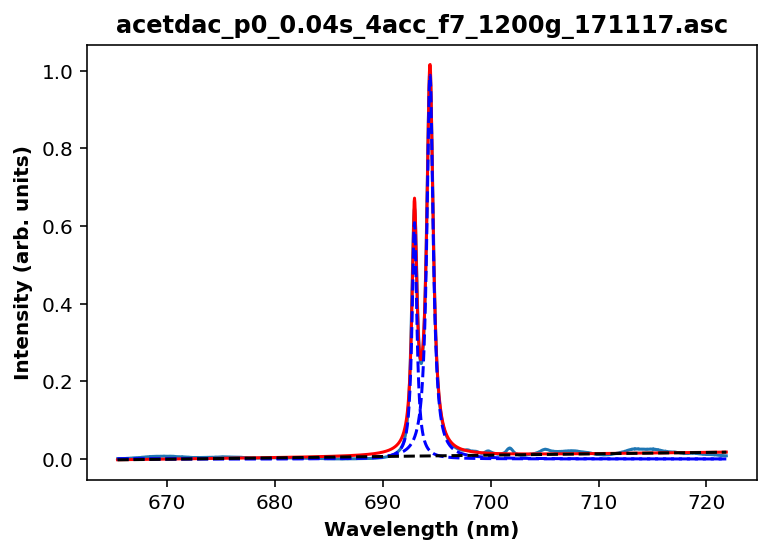

In [8]:
def calc_pressure(sample_lam,table_lam):
    a = 1920.0
    b = 9.61
    r1 = sample_lam
    r1_o = table_lam
    p = (a/b)*(((r1/r1_o)**b)-1)
    return p

def normalize(y):
    z = (y-np.min(y))/(np.max(y)-np.min(y))
    return z

def ruby_fit(x,y_data,ruby):
    y = normalize(y_data)
    background  = LinearModel(prefix='lin_')
    pars = background.guess(y, x=x)

    r1 = LorentzianModel(prefix='r1_')
    pars.update(r1.make_params())
    pars['r1_center'].set(694.3)
    pars['r1_sigma'].set(0.000954)
    r2 = LorentzianModel(prefix='r2_')
    pars.update(r2.make_params())

    pars['r2_center'].set(692.9)
    pars['r2_sigma'].set(0.00135)
    mod = r1 + r2 + background
    init = mod.eval(pars, x=x)
    plt.plot(x, y)

    out = mod.fit(y, pars, x=x)

    comps = out.eval_components(x=x)

    print(out.fit_report(min_correl=0.5))

    plt.plot(x, out.best_fit, 'r-')
    plt.plot(x, comps['r1_'], 'b--')
    plt.plot(x, comps['r2_'], 'b--')
    plt.plot(x, comps['lin_'], 'k--')
    plt.title(ruby,fontweight='bold')
    plt.xlabel('Wavelength (nm)',fontweight='bold')
    plt.ylabel('Intensity (arb. units)',fontweight='bold')

    r1_center = str(out.params['r1_center']).split()[2]
    r1_center = float(r1_center.strip('value='))
    r1_esd = str(out.params['r1_center']).split()[4]
    r1_esd = float(r1_esd.strip(','))
    r2_center = str(out.params['r2_center']).split()[2]
    r2_center = float(r2_center.strip('value='))
    r2_esd = str(out.params['r2_center']).split()[4]
    r2_esd = float(r2_esd.strip(','))

    ruby_cent = [r1_center,r2_center]
    ruby_esd = [r1_esd,r2_esd]
    #print(ruby_cent)
    #print(ruby_esd)
    return ruby_cent

def extract_ruby(ruby):    
    with open(ruby, "r") as f:
        data = np.loadtxt(f)

    x = data[:,0]
    y = data[:,1]
    
    y_norm = normalize(y)
    return x,y_norm

#table ruby wavelength
table_lam = []
for i in table_rubys:
    fig = plt.figure()
    x,y = extract_ruby(i)
    r1,r2 = ruby_fit(x,y,i)
    table_lam.append(r1)
    
sample_lam = []
for i in sample_rubys:
    fig = plt.figure()
    x,y = extract_ruby(i)
    r1,r2 = ruby_fit(x,y,i)
    sample_lam.append(r1)

dac_pressures = []
for i in range(len(sample_lam)):
    p = calc_pressure(sample_lam[i],table_lam[i])
    dac_pressures.append(p)
    
if dac_pressures[0] == 0:
    dac_pressures[0] = 1e-8

print(dac_pressures)

In [9]:
print('PRESSURES: \n')
for i in range(len(dac_pressures)): 
    print('P%s - %.3f GPa' % (i,dac_pressures[i]))

PRESSURES: 

P0 - 0.000 GPa


# 4. Retrieve Lattice Parameters

In [15]:
def extract_cell(log):
    lsqstart = []
    clsqstart = []
    stop = []
    with open(log, "r") as f:
        searchlines = f.readlines()
    for i, line in enumerate(searchlines):
        if ">lsq" in line: 
            #for l in searchlines[i:i+3]: print(l)
            lsqstart.append(i)
        if ">clsq" in line:
            clsqstart.append(i)
        if "Sigmas " in line:
            stop.append(i)
    lsqend = []
    clsqend = []
    for i, spot in enumerate(stop):
        if spot > lsqstart[len(lsqstart)-1]:
            lsqend.append(spot)
        if spot > clsqstart[len(clsqstart)-1]:
            clsqend.append(spot)

    lsq_range = [lsqstart[len(lsqstart)-1],lsqend[0]]
    clsq_range = [clsqstart[len(clsqstart)-1],clsqend[0]]

    lsq_dat = searchlines[lsq_range[0]:lsq_range[1]+1]
    clsq_dat = searchlines[clsq_range[0]:clsq_range[1]+1]

    key = ['a','b','c','alpha','beta','gamma','vol',\
           'a_sigma','b_sigma','c_sigma',\
           'alpha_sigma','beta_sigma','gamma_sigma','vol_sigma']
    lsq_cell = lsq_dat[len(lsq_dat)-2].split()
    del lsq_cell[0]
    lsq_cell = list(map(float,lsq_cell))
    lsq_sigma = lsq_dat[len(lsq_dat)-1].split()
    del lsq_sigma[0]
    lsq_sigma = list(map(float,lsq_sigma))
    lsq = lsq_cell+lsq_sigma
    clsq_cell = clsq_dat[len(clsq_dat)-2].split()
    del clsq_cell[0]
    clsq_cell = list(map(float,clsq_cell))
    clsq_sigma = clsq_dat[len(clsq_dat)-1].split()
    del clsq_sigma[0]
    clsq_sigma = list(map(float,clsq_sigma))
    clsq = clsq_cell+clsq_sigma

    lsq = dict(zip(key,lsq))
    clsq = dict(zip(key,clsq))
    cell = {"lsq":lsq,"clsq":clsq}
    return cell

os.chdir(log_folder)
logs = glob.glob('*.LOG')

lattice_params = []
for i in logs:
    cell = extract_cell(i)
    lattice_params.append(cell)
    #print(cell["lsq"]["a"])

for i in range(len(lattice_params)):
    cell_pandas = pd.DataFrame(lattice_params[i])
    print('P%s - %.3f GPa' % (i,dac_pressures[i]))
    display(cell_pandas)

P0 - 0.000 GPa


,clsq,lsq
a,7.10139,7.10140
a_sigma,0.00093,0.00023
alpha,90.00000,89.98100
alpha_sigma,0.00000,0.01500
b,9.38867,9.38859
b_sigma,0.00329,0.00532
beta,97.41500,97.41500
beta_sigma,0.01000,0.00300
c,11.70827,11.70820
c_sigma,0.00118,0.00068


# 5. Organize PV data into arrays.
Make a `numpy` array for volume and pressure data. [$P(GPa),\sigma_P,V({\unicode{x212B}}^3),\sigma_V$].

In [16]:
pv_lsq = np.zeros((len(lattice_params),4))
pv_clsq = np.zeros((len(lattice_params),4))

for i in range(len(lattice_params)):
    pv_lsq[i,0] = dac_pressures[i]
    pv_lsq[i,1] = 0.00001
    lp = lattice_params[i]
    pv_lsq[i,2] = lp["lsq"]["vol"]
    pv_lsq[i,3] = lp["lsq"]["vol_sigma"]
    
    pv_clsq[i,0] = dac_pressures[i]
    pv_clsq[i,1] = 0.0
    pv_clsq[i,2] = lp["clsq"]["vol"]
    pv_clsq[i,3] = lp["clsq"]["vol_sigma"]

# 6. Assign z (number of formula units per unit cell).

-- User edits this.

In [17]:
z = 4.

v_data = np.delete(pv_clsq,[0,1],1)
print('Least squares equation of state fitting\n')

print('- Room temperature PV data\n')
print('clsq: \n')
print(pv_clsq)

print('\nlsq: \n')
print(pv_lsq)

Least squares equation of state fitting

- Room temperature PV data

clsq: 

[[  1.00000000e-08   0.00000000e+00   7.74092400e+02   2.98500000e-01]]

lsq: 

[[  1.00000000e-08   1.00000000e-05   7.74082300e+02   4.42000000e-01]]


# 7. Plot the data.

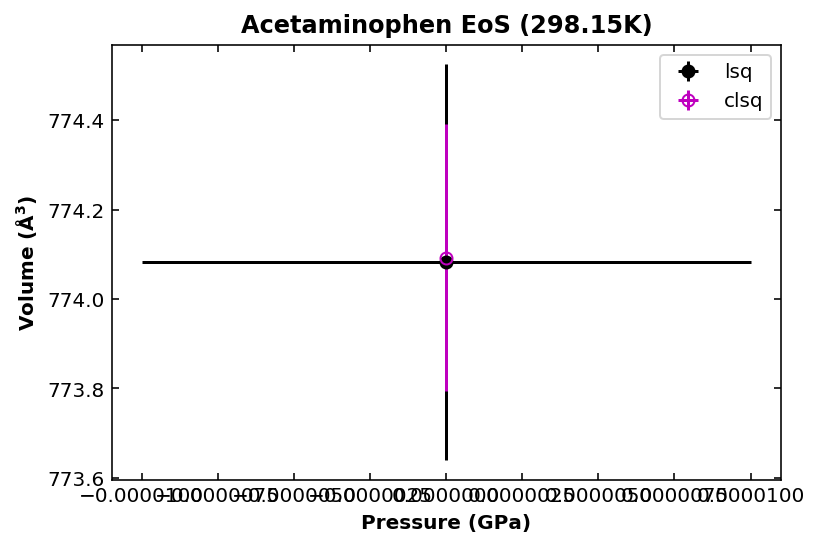

In [18]:
plt.errorbar(pv_lsq[:,0], pv_lsq[:,2], fmt='ko', \
             xerr=pv_lsq[:,1], yerr=pv_lsq[:,3],label='lsq')
plt.errorbar(pv_clsq[:,0], pv_clsq[:,2], fmt='mo', \
             xerr=pv_clsq[:,1], yerr=pv_clsq[:,3],label='clsq',fillstyle='none')
plt.xlabel('Pressure (GPa)',fontweight='bold')
plt.ylabel('Volume ($\mathbf{\AA^3}$)',fontweight='bold')
plt.tick_params(direction='in',bottom=1,top=1,left=1,right=1)
plt.title("%s EoS (%sK)" % (sample,T),fontweight='bold')
plt.legend()
#plt.savefig('PV-plot.png',dpi=800)
plt.show()

### Note - the following actions are performed with "clsq" data.

### F-${f}$ plot

Normalised pressure : $F_E=\frac{P}{3f_E(1+2f_E)^{5/2}}$

$\sigma_F=F_E\sqrt{(\frac{\sigma_P}{P})^2+(\sigma')^2}$

Eulerian Finite-strain : $f_E=\frac{1}{2}\left[\left(\frac{V}{V_0}\right)^{-2/3}-1\right]$

$\sigma_f=\frac{1}{3}\eta^{-5/3}\sigma_\eta$

$\sigma'=\frac{(7\eta^{-2/3}-5)\sigma_\eta}{3(1-\eta^{-2/3})\eta}$

$\eta=\frac{V}{V_0}$

In [14]:
p = pv_clsq[:,0]
sigP = pv_clsq[:,1]
V = pv_clsq[:,2]
sigV = pv_clsq[:,3]
Vo = pv_clsq[0,0]

sigVo = pv_clsq[0,1]
np.seterr(divide='ignore', invalid='ignore')
f = (1.0/2.0)*(((V/Vo)**(-2.0/3.0))-1.0)
F = p/(3.*f*(1.+(2.*f))**(5./2.))
eta = V/Vo
sigeta = np.abs(eta)*((((sigV/V)**2.0)+((sigVo/Vo)**2))**(1.0/2.0))
sigprime = ((7.0*(eta**(-2.0/3.0))-5.0)*sigeta)/(2.0*(1.0-(eta**-2.0/3.0))*eta)
sigF = F*np.sqrt(((sigP/p)**2.0)+(sigprime**2))

line_mod = LinearModel()
pars = line_mod.guess(np.delete(F,0), x=np.delete(f,0))
out = line_mod.fit(np.delete(F,0), pars, x=np.delete(f,0))
plt.plot(np.delete(f,0), out.best_fit, '-',color='black')

plt.errorbar(f, F, fmt='ko', xerr=0, yerr=sigF,\
             label=sample,alpha=1.0,capsize = 3.)
plt.xlabel('Eulerian strain $\mathit{f}$',fontweight='bold')
plt.ylabel('Normalised pressure $\mathbf{F_E}$ (GPa)',fontweight='bold')
plt.tick_params(direction='in',bottom=1,top=1,left=1,right=1)
plt.title("%s $\mathit{f}$-F (%sK)" % (sample,T),fontweight='bold')
plt.legend()
#plt.savefig('Ff-plot.png',dpi=800)
plt.show()

TypeError: expected non-empty vector for x

# 8. Find initial starting parameters from Burnman dictionary.

In [16]:
#smp = burnman.minerals.HP_2011_ds62.stv()
#smp = burnman.minerals.HP_2011_ds62.maj()
path = os.path.abspath(burnman.minerals.HP_2011_ds62.__file__)
print('Lookup file path: %s\n' % path)
smp = burnman.minerals.HP_2011_ds62.acet()
print(smp.params)

Lookup file path: C:\Users\Huber\Anaconda3\envs\py35ds\lib\site-packages\burnman\minerals\HP_2011_ds62.py

{'K_0': 10590000000.0, 'P_0': 100000.0, 'G_0': nan, 'name': 'acet', 'formula': {'C': 8.0, 'N': 1.0, 'O': 2.0, 'H': 9.0}, 'V_0': 0.0001164814528842654, 'Kdprime_0': -8.2e-11, 'T_einstein': 815.6441717791412, 'Gprime_0': nan, 'Kprime_0': 4.0, 'molar_mass': 0.15116256, 'S_0': 132.0, 'n': 20.0, 'equation_of_state': 'hp_tmt', 'Cp': [306.0, -0.003793, -3041700.0, -1852.1], 'H_0': -3091110.0, 'a_0': 2.11e-05, 'E_0': 0.0, 'T_0': 298.15}


### Create array in correct units for burnman (P(Pa),T(K),V(m$^3$/mol))

In [17]:
PTV = np.array([pv_clsq.T[0]*1.e9,
                pv_clsq.T[1]*0. + 298.15,
                burnman.tools.molar_volume_from_unit_cell_volume(pv_clsq.T[2], z)]).T
print(PTV)

[[  1.00000000e+01   2.98150000e+02   1.16462092e-04]
 [  4.26404455e+08   2.98150000e+02   1.12040877e-04]
 [  5.26988368e+08   2.98150000e+02   1.10841311e-04]
 [  5.22528067e+08   2.98150000e+02   1.10640488e-04]
 [  7.46864616e+08   2.98150000e+02   1.08604071e-04]
 [  8.25596642e+08   2.98150000e+02   1.08523269e-04]]


### Create covariance matrix.

In [18]:
nul = 0.*PTV.T[0]
PTV_covariances = np.array([[0.03*PTV.T[0], nul, nul], [nul, nul, nul], 
                            [nul, nul, burnman.tools.molar_volume_from_unit_cell_volume(pv_clsq.T[3], z)]]).T

# 9. Fit BM3 eos.

Birch-Murnaghan (isothermal): $P=3K_0f\left(1+2f\right)^{5/2}\left[1+\frac{3}{2}\left(K_0^\prime -4\right) f\right]$

In [22]:
help(burnman.eos_fitting.fit_PTV_data)
params = ['V_0', 'K_0', 'Kprime_0']
fitted_eos = burnman.eos_fitting.fit_PTV_data(smp, params, PTV, PTV_covariances, verbose=True)


Help on function fit_PTV_data in module burnman.eos_fitting:

fit_PTV_data(mineral, fit_params, data, data_covariances=[], param_tolerance=1e-05, max_lm_iterations=50, verbose=True)
    A simple alias for the fit_PTp_data for when all the data is volume data



NameError: name 'smp' is not defined

### Print optimized parameters.

In [20]:
print('Optimized equation of state for %s:' % sample)
print('volume:[m^3/mol]\nK:[Pa]\n')
burnman.tools.pretty_print_values(fitted_eos.popt, fitted_eos.pcov, fitted_eos.fit_params)
print(fitted_eos.pcov)

Optimized equation of state for Acetaminophen:
volume:[m^3/mol]
K:[Pa]

V_0: (1.165 +/- 0.003) x 1e-04
K_0: (9 +/- 1) x 1e+09
Kprime_0: (6 +/- 4) x 1e+00
[[  7.76949986e-14  -2.27677734e+02   3.58558373e-07]
 [ -2.27677734e+02   1.91481537e+18  -5.19318992e+09]
 [  3.58558373e-07  -5.19318992e+09   1.59786546e+01]]


### Create confidence ellipse plots.

In [21]:
def plt_ellipse(cov, pos, nstdl, ax=None):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()
    
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    palet = ['red', 'cyan', 'blue']

    for i in range(1,4):
        nstd = nstdl[i-1]
        hue = palet[i-1]
        width, height = 2 * nstd * np.sqrt(vals)
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, color = hue, alpha=0.8)
        ax.add_artist(ellip)
        ax.tick_params(direction='in',bottom=1,top=1,left=1,right=1)
        
    return ellip

V0 [A^3]: 773.675351546 +/- 1.85142282446
K0 [GPa]: 9.07368463432 +/- 1.3837685397
K0_prime: 5.9505602583 +/- 3.99733093497


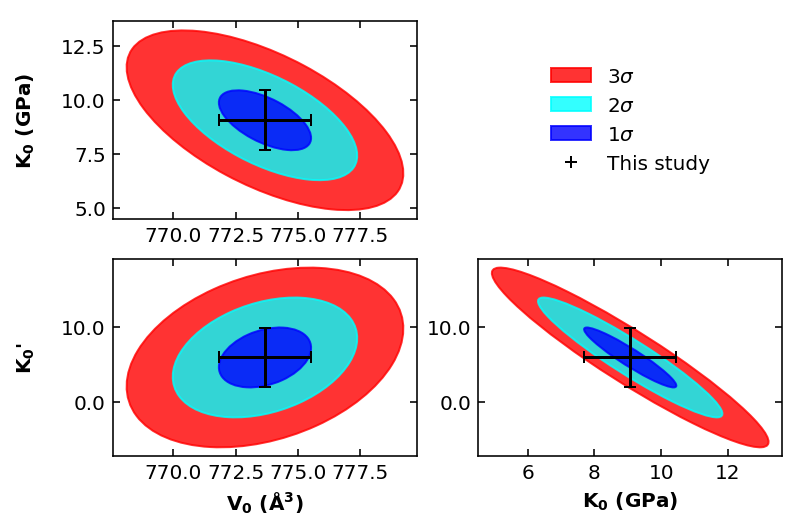

In [22]:
n_params = len(fitted_eos.pcov[0])
scaling = [(z/(con.N_A))*(1e30),1e-9,1e0]
scaling = np.outer(scaling,scaling)

fig, ax_array = plt.subplots(n_params-1, n_params-1)
nstd = [3.0,2.0,1.0]
err = [np.sqrt(fitted_eos.pcov[0,0])*(z/(con.N_A))*(1e30),np.sqrt(fitted_eos.pcov[1,1])*1e-9,\
        np.sqrt(fitted_eos.pcov[2,2])]
err = np.outer(err,err)


for i in range(n_params-1):
    
    for j in range(i+1, n_params):
        indices = np.array([i, j])
        projected_cov = (fitted_eos.pcov*scaling)[indices[:, None], indices]
        
        scaled_pos = np.array([fitted_eos.popt[i]*np.sqrt(scaling[i][i]),
                               fitted_eos.popt[j]*np.sqrt(scaling[j][j])]) 
        
        cov = projected_cov
        pos = scaled_pos
            
        ellipse = plt_ellipse(cov,pos,nstd,ax=ax_array[j-1][i])
        maxx = 1.5*2.2*np.sqrt(projected_cov[0][0])
        maxy = 1.5*2.2*np.sqrt(projected_cov[1][1])
        ax_array[j-1][i].set_xlim(scaled_pos[0]-maxx, scaled_pos[0]+maxx)
        ax_array[j-1][i].set_ylim(scaled_pos[1]-maxy, scaled_pos[1]+maxy)
        ax_array[j-1][i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
        
        if i == 0 and j == 1:
            ax_array[j-1][i].errorbar(pos[0],pos[1], xerr=np.sqrt(err[0,0]), yerr=np.sqrt(err[1,1]),\
                    linestyle='None', marker='None', label=sample,color='black', capsize = 3.)
            #ax_array[j-1][i].errorbar(shinmei_vo[0],shinmei_ko[0], xerr=shinmei_vo[1], yerr=shinmei_ko[1],\
            #        linestyle='None', marker='^', label='Shinmei et al. (1999)', color='black', capsize = 3.)
            #ax_array[j-1][i].errorbar(angel_vo[0],angel_ko[0], xerr=angel_vo[1], yerr=angel_ko[1],\
            #        linestyle='None', marker='o', label='Angel and Hugh-Jones (1994)',color='black', capsize = 3.)
            print('V0 [A^3]: %s +/- %s' % (pos[0],np.sqrt(err[0,0])))
            v0 = uct.ufloat(pos[0], np.sqrt(err[0,0]))
            print('K0 [GPa]: %s +/- %s' % (pos[1],np.sqrt(err[1,1])))
        if i == 0 and j == 2:
            ax_array[j-1][i].errorbar(pos[0],pos[1], xerr=np.sqrt(err[0,0]), yerr=np.sqrt(err[2,2]),\
                    linestyle='None', marker='None', label=sample,color='black', capsize = 3.)
            #ax_array[j-1][i].errorbar(shinmei_vo[0],shinmei_kp[0], xerr=shinmei_vo[1], yerr=shinmei_kp[1],\
            #        linestyle='None', marker='^', label='Shinmei et al. (1999)', color='black', capsize = 3.)
            #ax_array[j-1][i].errorbar(angel_vo[0],angel_kp[0], xerr=angel_vo[1], yerr=0.0,\
            #        linestyle='None', marker='o', label='Angel and Hugh-Jones (1994)',color='black', capsize = 3.)
        if i == 1 and j == 2:
            ax_array[j-1][i].errorbar(pos[0],pos[1], xerr=np.sqrt(err[1,1]), yerr=np.sqrt(err[2,2]),\
                    linestyle='None', marker='None', label=sample,color='black', capsize = 3.)
            #ax_array[j-1][i].errorbar(shinmei_ko[0],shinmei_kp[0], xerr=shinmei_ko[1], yerr=shinmei_kp[1],\
            #        linestyle='None', marker='^', label='Shinmei et al. (1999)', color='black', capsize = 3.)
            #ax_array[j-1][i].errorbar(angel_ko[0],angel_kp[0], xerr=angel_ko[1], yerr=0.0,\
            #        linestyle='None', marker='o', label='Angel and Hugh-Jones (1994)',color='black', capsize = 3.)
            print('K0_prime: %s +/- %s' % (pos[1],np.sqrt(err[2,2])))
        
red_patch = mpatches.Patch(color='red', alpha=0.8, label='3$\sigma$')
cyan_patch = mpatches.Patch(color='cyan', alpha=0.8, label='2$\sigma$')
blue_patch = mpatches.Patch(color='blue', alpha=0.8, label='1$\sigma$')
us = mlines.Line2D([],[],linestyle='none',marker='+', color='black', label='This study')
#shinmei = mlines.Line2D([],[],linestyle='none',marker='^', color='black', label='Shinmei et al. (1999)')
#ross = mlines.Line2D([],[],linestyle='none',marker='o', color='black', label='Angel and Hugh-Jones (1994)')

ax_array[0][1].set_axis_off()
legend = ax_array[0][1].legend(handles=[red_patch,cyan_patch,blue_patch,us], loc = 'center')
legend.get_frame().set_linewidth(0.0)
param_names = ['$\mathbf{V_0}$','$\mathbf{K_0}$','$\mathbf{K_0}$\'']
param_units = ['$\mathbf{\AA^3}$','GPa','']
if param_names != []:
    for i in range(n_params-1):
        ax_array[n_params-2][i].set_xlabel('{0:s} ({1:s})'.format(param_names[i],param_units[i]),fontweight='bold')
    for j in range(1, n_params):
        if param_units[j] == param_units[2]:
            ax_array[j-1][0].set_ylabel('{0:s}'.format(param_names[j]),fontweight='bold')
        else:
            ax_array[j-1][0].set_ylabel('{0:s} ({1:s})'.format(param_names[j],param_units[j]),fontweight='bold')
        ax_array[j-1][0].yaxis.set_label_coords(-0.25,0.5)

#fig.savefig('confidence-ellipse.png',dpi=800)
plt.show()

# 10. Plot data and new EoS.

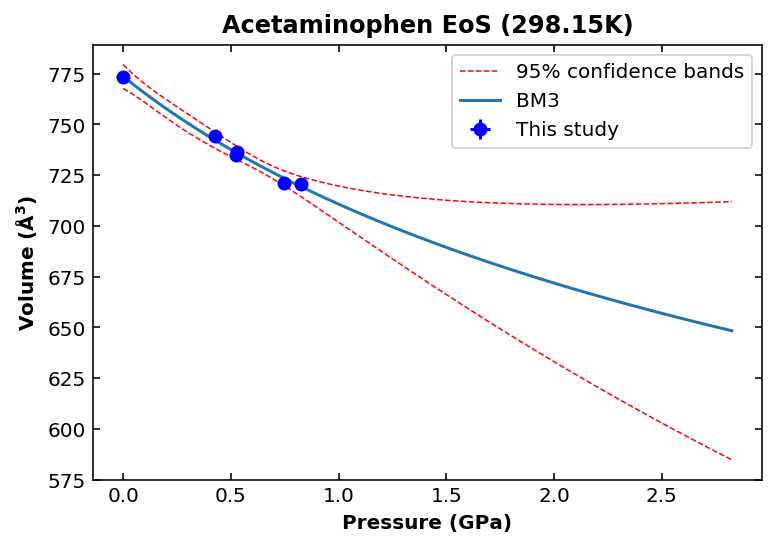

In [23]:
maxp = np.amax(pv_clsq[:,0])*1.e9+(2.e9)
pressures = np.linspace(1.e5, maxp, 101)
volumes = np.empty_like(pressures)

PTVs = np.empty((len(pressures), 3))
for i, P in enumerate(pressures):
    smp.set_state(P, T)
    PTVs[i] = [P, T, smp.V]

# Plot the 95% confidence and prediction bands 
cp_bands = burnman.nonlinear_fitting.confidence_prediction_bands(model = fitted_eos, x_array = PTVs,
                                                                 confidence_interval = 0.95,
                                                                 f=burnman.tools.attribute_function(smp, 'V'),
                                                                 flag='V')

plt.plot(PTVs[:,0]/1.e9, cp_bands[0] * (z/(con.N_A))*(1e30), linestyle='--', linewidth=0.75, color='r', label='95% confidence bands')
plt.plot(PTVs[:,0]/1.e9, cp_bands[1] * (z/(con.N_A))*(1e30), linestyle='--', linewidth=0.75, color='r')


plt.plot(PTVs[:,0] / 1.e9, PTVs[:,2] * (z/(con.N_A))*(1e30), label='BM3 %s' % '')


#clino1 = np.delete(PTV, (6,7,8,9,10,11), axis=0)

#cov11 = np.delete(PTV_covariances.T[0][0],(6,7,8,9,10,11))
#cov21 = np.delete(PTV_covariances.T[2][2],(6,7,8,9,10,11))
#cov12 = np.delete(PTV_covariances.T[0][0],(0,1,2,3,4,5))
#cov22 = np.delete(PTV_covariances.T[2][2],(0,1,2,3,4,5))
cov11 = PTV_covariances.T[0][0]
cov21 = PTV_covariances.T[2][2]
cov12 = PTV_covariances.T[0][0]
cov22 = PTV_covariances.T[2][2]

plt.errorbar(PTV[:,0] / 1.e9, PTV[:,2] * (z/(con.N_A))*(1e30), xerr=cov11 / 1.e9, 
             yerr=cov21 * (z/(con.N_A))*(1e30),
             linestyle='None', marker='o', label='This study',color='blue', alpha=1.0)


#plt.xlim([2.5,37.5])
#plt.ylim([325,400])
plt.ylabel("Volume ($\mathbf{\AA^3}$)",fontweight='bold')
plt.xlabel("Pressure (GPa)",fontweight='bold')
plt.tick_params(direction='in',bottom=1,top=1,left=1,right=1)
plt.legend(loc="upper right")
plt.title("%s EoS (%sK)" % (sample,T),fontweight='bold')
#plt.savefig('PV_eos-plot.png',dpi=800)
plt.show()

### Plot bulk modulus.

Isothermal bulk modulus: 
$K_{T}=(1+2f)^{5/2}\biggl[  K_0+(3K_0{K}^\prime_{0}-5K_0)f+\frac{27}{2}(K_0{K}^\prime_{0}-4K_0)f^2 \biggr]$

Shear modulus: $G = (1+2f)^{5/2}  \biggl[G_0+(3K_0{G}^\prime_{0}-5G_0)f+(6K_0{G}^\prime_{0}-24K_0-14G_{0}
     + \frac{9}{2}K_{0}{K}^\prime_{0})f^2 \biggr]$

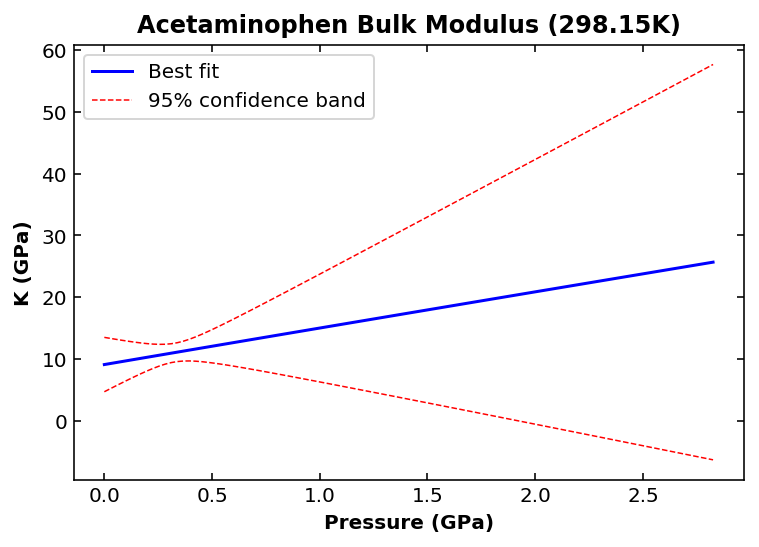

In [24]:
cp_bands = burnman.nonlinear_fitting.confidence_prediction_bands(model = fitted_eos, x_array = PTVs,
                                                                 confidence_interval = 0.95,
                                                                 f=burnman.tools.attribute_function(smp, 'K_T'),
                                                                 flag='V')
array = np.array([[6.37389300e+09,2.98150000e+02,2.89943113e-05]])
plt.plot(PTVs[:,0]/1.e9, (cp_bands[0] + cp_bands[1])/2.e9, color='b', label='Best fit')
plt.plot(PTVs[:,0]/1.e9, (cp_bands[0])/1.e9, linestyle='--', linewidth=0.75, color='r', label='95% confidence band')
plt.plot(PTVs[:,0]/1.e9, (cp_bands[1])/1.e9, linestyle='--', linewidth=0.75, color='r')
cp_bands2 = burnman.nonlinear_fitting.confidence_prediction_bands(model = fitted_eos, x_array = array,
                                                                 confidence_interval = 0.95,
                                                                 f=burnman.tools.attribute_function(smp, 'K_T'),
                                                                 flag='V')
scale = (z/(con.N_A))*(1e30)
#print(scale*array[0,2])
#print((cp_bands2[0] + cp_bands2[1])/2.e9)
plt.ylabel("K (GPa)",fontweight='bold')
plt.xlabel("Pressure (GPa)",fontweight='bold')
plt.tick_params(direction='in',bottom=1,top=1,left=1,right=1)
plt.legend(loc="upper left")
plt.title("%s Bulk Modulus (%sK)" % (sample,T),fontweight='bold')
#plt.savefig('PK-plot.png',dpi=800)
plt.show()

### Miscellaneous plots.

a reduction: 1.422%
b reduction: 4.266%
c reduction: 1.021%

a: [[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 6
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -63.999
    Bayesian info crit = -64.416
[[Variables]]
    slope:      -0.12748251 +/- 0.006513 (5.11%) (init=-0.1274825)
    intercept:   7.10017423 +/- 0.003733 (0.05%) (init= 7.100174)
[[Correlations]] (unreported correlations are <  0.100)
    C(slope, intercept)          = -0.886 

b: [[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 6
    # variables        = 2
    chi-square         = 0.001
    reduced chi-square = 0.000
    Akaike info crit   = -46.964
    Bayesian info crit = -47.381
[[Variables]]
    slope:      -0.50333663 +/- 0.026934 (5.35%) (init=-0.5033366)
    intercept:   9.37154887 +/- 0.015441 (0.16%) (init= 9.371549)
[[Correlations]] (unreporte

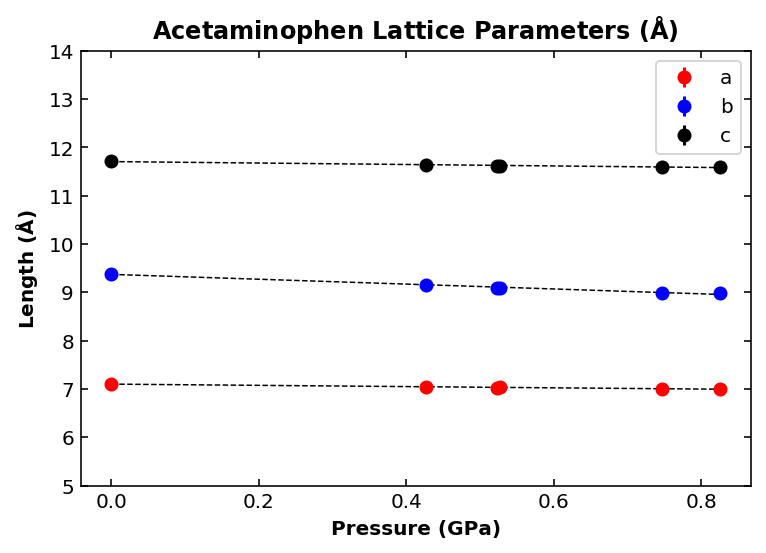

In [25]:
a_len = []
b_len = []
c_len = []
a_sigma = []
b_sigma = []
c_sigma = []
beta_angle = []
beta_sigma = []

if len(dac_pressures) != len(lattice_params):
    x = len(dac_pressures)-len(lattice_params)
    del dac_pressures[(len(dac_pressures)-x):]
    
for i in range(len(lattice_params)):
    n_cell = lattice_params[i]
    a_len.append(n_cell["clsq"]["a"])
    b_len.append(n_cell["clsq"]["b"])
    c_len.append(n_cell["clsq"]["c"])
    a_sigma.append(n_cell["clsq"]["a_sigma"])
    b_sigma.append(n_cell["clsq"]["b_sigma"])
    c_sigma.append(n_cell["clsq"]["c_sigma"])
    beta_angle.append(n_cell["clsq"]["beta"])
    beta_sigma.append(n_cell["clsq"]["beta_sigma"])

print('a reduction: %.3f%%' % ((1-(a_len[len(a_len)-1]/a_len[0]))*100))
print('b reduction: %.3f%%' % ((1-(b_len[len(b_len)-1]/b_len[0]))*100))
print('c reduction: %.3f%%\n' % ((1-(c_len[len(c_len)-1]/c_len[0]))*100))                         

pars = line_mod.guess(a_len, x=dac_pressures)
out = line_mod.fit(a_len, pars, x=dac_pressures)
plt.plot(dac_pressures, out.best_fit, '-',color='black',linestyle='--', linewidth=0.75)
plt.errorbar(dac_pressures, a_len,yerr=a_sigma, color='red',marker='o',linestyle='none',
         label='a')
print('a: %s' % out.fit_report())

pars = line_mod.guess(b_len, x=dac_pressures)
out = line_mod.fit(b_len, pars, x=dac_pressures)
plt.plot(dac_pressures, out.best_fit, '-',color='black',linestyle='--', linewidth=0.75)
plt.errorbar(dac_pressures, b_len,yerr=b_sigma,color='blue',marker='o',linestyle='none',
        label='b')
print('b: %s' % out.fit_report())

pars = line_mod.guess(c_len, x=dac_pressures)
out = line_mod.fit(c_len, pars, x=dac_pressures)
plt.plot(dac_pressures, out.best_fit, '-',color='black',linestyle='--', linewidth=0.75)
plt.errorbar(dac_pressures, c_len,yerr=c_sigma,color='black',marker='o',linestyle='none',
        label='c')
print('c: %s' % out.fit_report())

plt.ylim([5.0,14.0])
plt.ylabel("Length ($\mathbf{\AA}$)",fontweight='bold')
plt.xlabel("Pressure (GPa)",fontweight='bold')
plt.tick_params(direction='in',bottom=1,top=1,left=1,right=1)
plt.legend(loc="upper right")
plt.title("%s Lattice Parameters ($\mathbf{\AA}$)" % (sample),fontweight='bold')
#plt.savefig('lattice_parameters-plot.png',dpi=800)
plt.show()

beta_angle increase: 1.013%


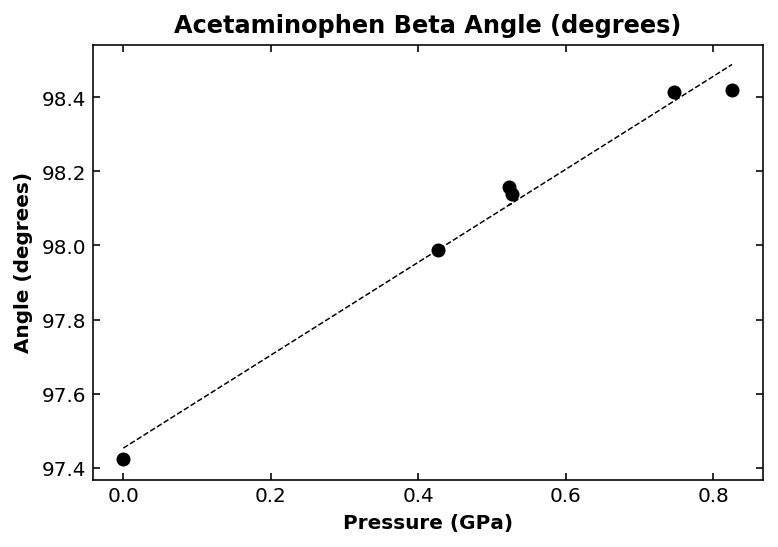

In [26]:
print('beta_angle increase: %.3f%%' % ((1-(beta_angle[0]/beta_angle[len(beta_angle)-1]))*100))  

plt.errorbar(dac_pressures, beta_angle, yerr = beta_sigma, color='black',marker='o',linestyle='none')
pars = line_mod.guess(beta_angle, x=dac_pressures)
out = line_mod.fit(beta_angle, pars, x=dac_pressures)
plt.plot(dac_pressures, out.best_fit, '-',color='black',linestyle='--', linewidth=0.75)

plt.ylabel("Angle (degrees)",fontweight='bold')
plt.xlabel("Pressure (GPa)",fontweight='bold')
plt.tick_params(direction='in',bottom=1,top=1,left=1,right=1)
plt.title("%s Beta Angle (degrees)" % (sample),fontweight='bold')
#plt.savefig('angle-plot.png',dpi=800)
plt.show()

### Density.

V_0 [A^3]: 773.7+/-1.9
Density_0 [g/cm^3]: 1.2978+/-0.0031


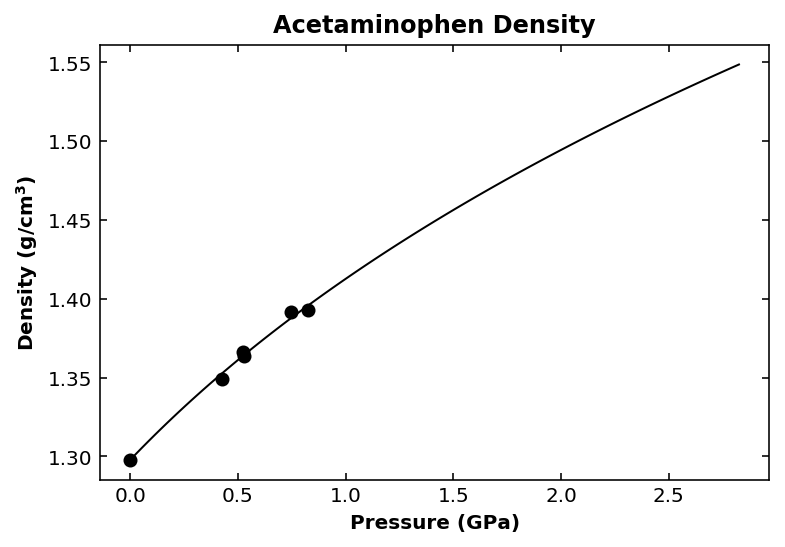

In [27]:
print('V_0 [A^3]: %s' % v0)
#Acetaminophen = C8H9NO2
mass = (((12.011*8)+(1.008*9)+(14.007)+(15.999*2))/(con.N_A))*z
vol_cm3 = v0*(1e-24)
den = mass/vol_cm3
print('Density_0 [g/cm^3]: %s' % den)

volumes = (PTVs[:,2] * (z/(con.N_A))*(1e30))*(1e-24)
densities = mass/volumes

obs_densities = mass/(pv_clsq[:,2]*(1e-24))

plt.plot((PTVs[:,0]*1e-9), densities, '-',color='black',linestyle='-', linewidth=1.0)
plt.plot(dac_pressures,obs_densities,'ko')
plt.ylabel("Density $\mathbf{(g/cm^3)}$",fontweight='bold')
plt.xlabel("Pressure (GPa)",fontweight='bold')
plt.tick_params(direction='in',bottom=1,top=1,left=1,right=1)
plt.title("%s Density" % (sample),fontweight='bold')
#plt.savefig('density-plot.png',dpi=800)
plt.show()